In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
#import spacy
from torchtext.legacy.data import Field, BucketIterator
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from dataloader import *
from transformer import *

# Model definition

In [3]:
class TransformerClassifier(torch.nn.Module):

    def __init__(self, src_pad_idx, enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super(TransformerClassifier, self).__init__()

        self.src_pad_idx = src_pad_idx
        self.encoder = Encoder(enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device)
        self.linear = nn.Linear(d_model * max_len, 2).to(device)

    def make_pad_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)

        # batch_size x 1 x 1 x len_k
        k = k.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # batch_size x 1 x len_q x len_k
        k = k.repeat(1, 1, len_q, 1)

        # batch_size x 1 x len_q x 1
        q = q.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(3)
        # batch_size x 1 x len_q x len_k
        q = q.repeat(1, 1, 1, len_k)

        mask = k & q
        return mask

    def forward(self, x):
        mask = self.make_pad_mask(x, x)
        x = self.encoder(x, mask)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.kaiming_uniform(m.weight.data)

In [5]:
def plot_training(history, marker=None):
  plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.5,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

  plt.subplot(1, 2, 1)
  plt.plot(history['train_loss'])
  plt.plot(history['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.title('Training loss')

  # vertical line for marking best epoch
  if marker is not None:
    y_min = min(history['train_loss'] + history['val_loss'])
    y_max = max(history['train_loss'] + history['val_loss'])
    plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

  plt.subplot(1, 2, 2)
  plt.plot(history['train_acc'])
  plt.plot(history['val_acc'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.title('Training metric')

  # vertical line for marking best epoch
  if marker is not None:
    y_min = min(history['train_acc'] + history['val_acc'])
    y_max = max(history['train_acc'] + history['val_acc'])
    plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

  plt.show()

In [22]:
def validation(model, iterator, optimizer, criterion, device):
    # set model into evaluation mode
    model.eval()

    # validation
    # loss, metrics for current epoch
    val_epoch_loss = 0
    val_epoch_accuracy = 0

    with torch.no_grad(): # stop graph
        # batches
        for i, batch in enumerate(iterator):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            output = model(src)
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)

            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy

            val_epoch_loss += loss.item()
            val_epoch_accuracy += accuracy

    # return mean loss w.r.t. batches
    return val_epoch_loss / len(iterator), val_epoch_accuracy / len(iterator)

def train(model, iterator, optimizer, criterion, epoch, clip, device):
    # set model into training mode
    model.train()

    scheduler = ReduceLROnPlateau(optimizer, 'min')

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': []}

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            epoch_acc += accuracy / len(iterator)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)

        # save data
        with torch.no_grad():
          for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc]):
            history[key].append(value)

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}")

    # print training curve
    plot_training(history)

    return history

def train_save_best(model, iterator, optimizer, criterion, epoch, clip, device):
    # set model into training mode
    model.train()

    scheduler = ReduceLROnPlateau(optimizer, 'min')

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': [],
               'learning_rate': []}
    best_model = None
    best_model_score = 1e9
    best_model_epoch = 0

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            epoch_acc += accuracy / len(iterator)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)
        
        scheduler.step(val_loss)

        # save data
        with torch.no_grad():
            current_lr = optimizer.param_groups[0]['lr']

            for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc, current_lr]):
                history[key].append(value)

            # save best model (w.r.t validation loss)
            if val_loss < best_model_score:
                best_model = model.state_dict()
                best_model_score = val_loss
                best_model_epoch = e

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}")

    # print training curve
    plot_training(history, marker=best_model_epoch)

    return history, best_model, best_model_score

# Import data

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [24]:
# init
tokenizer = Tokenizer()
loader = DataLoader(tokenize = tokenizer.tokenize)

# import data (combine train/test as we split afterwards anyways)
data = pd.concat([pd.read_csv("./Data/SMS_train.csv", encoding='ISO-8859-1'),
                  pd.read_csv("./Data/SMS_test.csv", encoding='ISO-8859-1')])

# convert string label to binary (int) label (spam:1, non-spam:0)
labels = pd.Series((data['Label'] == 'Spam').astype(int))
data['Label'] = labels

# train, test, val split
train, valid, test = loader.make_dataset(data[['Message_body', 'Label']])
vocab = loader.get_vocab(train.iloc[:, 0])
train_iter, valid_iter, test_iter = loader.make_iter(train, valid, test,
                                                     batch_size=128,
                                                     device=device)

# NLP stuff
pad_idx = vocab['__PAD__']
voc_size = len(vocab)
print("Vocabulary Size : ", voc_size)

dataset initializing start
1
Message_body    [[CLS], free, ##ms, ##g, hey, there, darling, ...
Label                                                           1
len                                                           147
Name: 64, dtype: object


100%|██████████| 108/108 [00:00<00:00, 16617.20it/s]

dataset initializing done
Vocabulary Size :  2707


# Training

Idea: We train model A and model B for long enough, s.t. they start overfitting. We use their best models w.r.t. validation set (i.e. not the final model after all training epochs) and fuse them together. The fused model is then trained for long enough as well, saving the best model w.r.t to the same validation set. The fused model is then compared with its parent models on the separate test set.


note that dataset is imbalanced -> accuracy is not a good metric

  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_20308\428977846.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 7/7 [01:04<00:00,  9.24s/it]
C:\Users\jjung\AppData\Local\Temp\ipykernel_20308\428977846.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 18.2863               Validation Loss: 0.6228               Train acc: 0.4783,               Val acc: 0.8505


100%|██████████| 7/7 [00:50<00:00,  7.25s/it]


Epoch: 2  Train Loss: 8.3654               Validation Loss: 6.8332               Train acc: 0.6964,               Val acc: 0.8224


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]


Epoch: 3  Train Loss: 3.9681               Validation Loss: 4.3951               Train acc: 0.8216,               Val acc: 0.8224


100%|██████████| 7/7 [00:48<00:00,  6.90s/it]


Epoch: 4  Train Loss: 11.7395               Validation Loss: 7.8026               Train acc: 0.4804,               Val acc: 0.8224


100%|██████████| 7/7 [00:48<00:00,  6.86s/it]


Epoch: 5  Train Loss: 3.8009               Validation Loss: 0.9820               Train acc: 0.7443,               Val acc: 0.8879


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 6  Train Loss: 1.1231               Validation Loss: 1.0856               Train acc: 0.8820,               Val acc: 0.8411


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]


Epoch: 7  Train Loss: 1.9365               Validation Loss: 0.2739               Train acc: 0.7110,               Val acc: 0.9252


100%|██████████| 7/7 [00:49<00:00,  7.01s/it]


Epoch: 8  Train Loss: 0.4658               Validation Loss: 0.7533               Train acc: 0.9190,               Val acc: 0.8785


100%|██████████| 7/7 [00:49<00:00,  7.06s/it]


Epoch: 9  Train Loss: 1.1959               Validation Loss: 0.2067               Train acc: 0.7819,               Val acc: 0.9533


100%|██████████| 7/7 [00:48<00:00,  6.91s/it]


Epoch: 10  Train Loss: 0.3930               Validation Loss: 5.1039               Train acc: 0.9236,               Val acc: 0.3551


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 11  Train Loss: 0.6359               Validation Loss: 0.1956               Train acc: 0.8784,               Val acc: 0.9626


100%|██████████| 7/7 [00:48<00:00,  6.98s/it]


Epoch: 12  Train Loss: 0.1953               Validation Loss: 0.3788               Train acc: 0.9743,               Val acc: 0.9439


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 13  Train Loss: 0.3250               Validation Loss: 1.1701               Train acc: 0.9098,               Val acc: 0.8692


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 14  Train Loss: 0.0530               Validation Loss: 1.1832               Train acc: 0.9866,               Val acc: 0.9159


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 15  Train Loss: 0.2068               Validation Loss: 3.3826               Train acc: 0.9651,               Val acc: 0.5888


100%|██████████| 7/7 [00:48<00:00,  6.91s/it]


Epoch: 16  Train Loss: 0.4170               Validation Loss: 0.3131               Train acc: 0.9121,               Val acc: 0.9439


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 17  Train Loss: 0.0180               Validation Loss: 0.3328               Train acc: 0.9933,               Val acc: 0.9626


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 18  Train Loss: 0.0080               Validation Loss: 0.2593               Train acc: 0.9973,               Val acc: 0.9533


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 19  Train Loss: 0.0077               Validation Loss: 0.1964               Train acc: 0.9989,               Val acc: 0.9626


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 20  Train Loss: 0.0214               Validation Loss: 0.2185               Train acc: 0.9906,               Val acc: 0.9626


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 21  Train Loss: 0.0096               Validation Loss: 0.8416               Train acc: 0.9967,               Val acc: 0.9065


100%|██████████| 7/7 [00:48<00:00,  6.98s/it]


Epoch: 22  Train Loss: 0.0514               Validation Loss: 1.0164               Train acc: 0.9911,               Val acc: 0.8692


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 23  Train Loss: 0.1146               Validation Loss: 0.3739               Train acc: 0.9711,               Val acc: 0.9533


100%|██████████| 7/7 [00:48<00:00,  6.90s/it]


Epoch: 24  Train Loss: 0.0005               Validation Loss: 1.1711               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 25  Train Loss: 0.0043               Validation Loss: 0.5767               Train acc: 0.9989,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.98s/it]


Epoch: 26  Train Loss: 0.0000               Validation Loss: 0.3821               Train acc: 1.0000,               Val acc: 0.9439


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 27  Train Loss: 0.0026               Validation Loss: 0.3912               Train acc: 0.9989,               Val acc: 0.9346


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 28  Train Loss: 0.0000               Validation Loss: 0.3649               Train acc: 1.0000,               Val acc: 0.9439


100%|██████████| 7/7 [00:48<00:00,  6.91s/it]


Epoch: 29  Train Loss: 0.0000               Validation Loss: 0.3767               Train acc: 1.0000,               Val acc: 0.9439


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 30  Train Loss: 0.0000               Validation Loss: 0.3905               Train acc: 1.0000,               Val acc: 0.9439


100%|██████████| 7/7 [00:48<00:00,  6.92s/it]


Epoch: 31  Train Loss: 0.0000               Validation Loss: 0.3992               Train acc: 1.0000,               Val acc: 0.9346


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 32  Train Loss: 0.0000               Validation Loss: 0.4039               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 33  Train Loss: 0.0000               Validation Loss: 0.4063               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 34  Train Loss: 0.0000               Validation Loss: 0.4064               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 35  Train Loss: 0.0000               Validation Loss: 0.4065               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 36  Train Loss: 0.0000               Validation Loss: 0.4065               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 37  Train Loss: 0.0000               Validation Loss: 0.4065               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 38  Train Loss: 0.0000               Validation Loss: 0.4065               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 39  Train Loss: 0.0000               Validation Loss: 0.4065               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 40  Train Loss: 0.0000               Validation Loss: 0.4065               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 41  Train Loss: 0.0000               Validation Loss: 0.4065               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 42  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 43  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]


Epoch: 44  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 45  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 46  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 47  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.92s/it]


Epoch: 48  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 49  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.91s/it]


Epoch: 50  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 51  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 52  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:49<00:00,  7.00s/it]


Epoch: 53  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.91s/it]


Epoch: 54  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 55  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 56  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.91s/it]


Epoch: 57  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 58  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:49<00:00,  7.03s/it]


Epoch: 59  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 60  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]


Epoch: 61  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.92s/it]


Epoch: 62  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.91s/it]


Epoch: 63  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 64  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 65  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 66  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.91s/it]


Epoch: 67  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 68  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 69  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 70  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 71  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 72  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.92s/it]


Epoch: 73  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 74  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.98s/it]


Epoch: 75  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.98s/it]


Epoch: 76  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:49<00:00,  7.01s/it]


Epoch: 77  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 78  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.92s/it]


Epoch: 79  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 80  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.92s/it]


Epoch: 81  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]


Epoch: 82  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]


Epoch: 83  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  7.00s/it]


Epoch: 84  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 85  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 86  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.98s/it]


Epoch: 87  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.91s/it]


Epoch: 88  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 89  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.91s/it]


Epoch: 90  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 91  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:49<00:00,  7.01s/it]


Epoch: 92  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 93  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]


Epoch: 94  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]


Epoch: 95  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 96  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.98s/it]


Epoch: 97  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 98  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 99  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.90s/it]


Epoch: 100  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.92s/it]


Epoch: 101  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 102  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 103  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 104  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 105  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 106  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  7.00s/it]


Epoch: 107  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 108  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 109  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.91s/it]


Epoch: 110  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.91s/it]


Epoch: 111  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 112  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 113  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 114  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 115  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 116  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.98s/it]


Epoch: 117  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 118  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.98s/it]


Epoch: 119  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]


Epoch: 120  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 121  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 122  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 123  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 124  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:49<00:00,  7.01s/it]


Epoch: 125  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.92s/it]


Epoch: 126  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]


Epoch: 127  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 128  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:49<00:00,  7.00s/it]


Epoch: 129  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]


Epoch: 130  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:49<00:00,  7.02s/it]


Epoch: 131  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 132  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 133  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 134  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]


Epoch: 135  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.91s/it]


Epoch: 136  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 137  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 138  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 139  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 140  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.91s/it]


Epoch: 141  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 142  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:49<00:00,  7.01s/it]


Epoch: 143  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:49<00:00,  7.01s/it]


Epoch: 144  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:49<00:00,  7.01s/it]


Epoch: 145  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 146  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 147  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 148  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 149  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]


Epoch: 150  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]


Epoch: 151  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  7.00s/it]


Epoch: 152  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 153  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 154  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.98s/it]


Epoch: 155  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]


Epoch: 156  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.98s/it]


Epoch: 157  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:49<00:00,  7.00s/it]


Epoch: 158  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 159  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 160  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 161  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 162  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:49<00:00,  7.00s/it]


Epoch: 163  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 164  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 165  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 166  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.96s/it]


Epoch: 167  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.92s/it]


Epoch: 168  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.92s/it]


Epoch: 169  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 170  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.97s/it]


Epoch: 171  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 172  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.92s/it]


Epoch: 173  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 174  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  7.00s/it]


Epoch: 175  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:50<00:00,  7.17s/it]


Epoch: 176  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 177  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 178  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 179  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 180  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.36s/it]


Epoch: 181  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 182  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 183  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 184  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 185  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 186  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 187  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 188  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 189  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 190  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 191  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 192  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 193  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 194  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 195  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 196  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.35s/it]


Epoch: 197  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 198  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 199  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 200  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 201  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 202  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 203  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 204  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 205  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 206  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 207  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 208  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 209  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 210  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 211  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 212  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 213  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 214  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 215  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 216  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 217  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 218  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 219  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 220  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 221  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 222  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 223  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 224  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 225  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 226  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 227  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 228  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 229  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 230  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 231  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 232  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 233  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 234  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 235  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 236  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 237  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 238  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 239  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 240  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 241  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 242  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 243  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.36s/it]


Epoch: 244  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 245  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 246  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 247  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 248  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 249  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 250  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 251  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 252  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 253  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.36s/it]


Epoch: 254  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 255  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 256  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.36s/it]


Epoch: 257  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 258  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 259  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 260  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 261  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 262  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 263  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 264  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.36s/it]


Epoch: 265  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 266  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 267  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 268  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 269  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 270  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 271  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 272  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 273  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 274  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 275  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 276  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 277  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 278  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 279  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 280  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 281  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 282  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 283  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 284  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 285  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 286  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 287  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 288  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 289  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 290  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 291  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 292  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 293  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 294  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 295  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 296  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 297  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 298  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 299  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 300  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 301  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 302  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 303  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 304  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 305  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 306  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 307  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 308  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 309  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 310  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 311  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 312  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 313  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 314  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 315  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 316  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 317  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 318  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 319  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 320  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 321  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 322  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 323  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 324  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 325  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 326  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 327  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 328  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 329  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 330  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 331  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 332  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 333  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 334  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 335  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 336  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 337  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 338  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 339  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 340  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 341  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 342  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 343  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 344  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 345  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 346  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 347  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 348  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 349  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 350  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 351  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 352  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 353  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 354  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 355  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 356  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 357  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 358  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 359  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 360  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 361  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 362  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 363  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 364  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 365  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 366  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 367  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 368  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 369  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 370  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 371  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 372  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 373  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 374  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 375  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 376  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 377  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 378  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 379  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 380  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 381  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 382  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 383  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 384  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 385  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 386  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 387  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 388  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 389  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 390  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 391  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 392  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 393  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 394  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 395  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 396  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 397  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 398  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 399  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 400  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 401  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 402  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 403  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 404  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 405  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 406  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 407  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 408  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 409  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 410  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 411  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 412  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 413  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 414  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 415  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 416  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 417  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 418  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 419  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 420  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 421  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 422  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 423  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 424  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 425  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 426  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 427  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 428  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 429  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 430  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 431  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 432  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 433  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 434  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 435  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 436  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 437  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 438  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 439  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 440  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 441  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 442  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 443  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 444  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 445  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 446  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 447  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 448  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 449  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 450  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 451  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 452  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 453  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 454  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 455  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 456  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 457  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 458  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 459  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 460  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 461  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 462  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 463  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 464  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 465  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 466  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 467  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 468  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 469  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 470  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 471  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 472  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 473  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 474  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 475  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 476  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 477  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 478  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 479  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 480  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 481  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 482  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 483  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 484  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 485  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 486  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 487  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 488  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 489  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 490  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 491  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 492  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 493  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 494  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 495  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 496  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 497  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 498  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 499  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 500  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 501  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 502  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 503  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 504  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 505  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 506  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 507  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 508  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 509  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 510  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 511  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 512  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 513  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 514  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 515  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 516  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 517  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 518  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 519  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 520  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 521  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 522  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 523  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 524  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 525  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 526  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 527  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 528  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 529  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 530  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 531  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 532  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 533  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 534  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 535  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 536  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 537  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 538  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 539  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 540  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 541  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 542  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 543  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


Epoch: 544  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 545  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 546  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 547  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 548  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 549  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 550  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 551  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 552  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 553  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 554  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 555  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 556  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 557  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 558  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 559  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 560  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 561  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 562  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 563  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 564  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 565  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 566  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 567  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 568  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 569  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.46s/it]


Epoch: 570  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 571  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 572  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:49<00:00,  7.05s/it]


Epoch: 573  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 574  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 575  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Epoch: 576  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.46s/it]


Epoch: 577  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 578  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 579  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 580  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 581  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 582  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 583  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 584  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 585  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 586  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 587  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 588  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 589  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 590  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 591  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.46s/it]


Epoch: 592  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 593  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 594  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 595  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 596  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Epoch: 597  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Epoch: 598  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 599  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 600  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 601  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 602  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 603  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 604  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 605  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 606  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 607  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 608  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 609  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 610  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 611  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 612  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 613  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 614  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 615  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 616  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 617  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 618  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 619  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 620  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 621  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 622  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 623  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Epoch: 624  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Epoch: 625  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 626  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 627  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.46s/it]


Epoch: 628  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 629  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 630  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 631  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 632  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Epoch: 633  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 634  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 635  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 636  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.46s/it]


Epoch: 637  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 638  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 639  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 640  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 641  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 642  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Epoch: 643  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 644  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 645  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 646  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Epoch: 647  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 648  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 649  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 650  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 651  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 652  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 653  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 654  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 655  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 656  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Epoch: 657  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 658  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 659  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 660  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 661  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 662  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 663  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.47s/it]


Epoch: 664  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.46s/it]


Epoch: 665  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 666  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Epoch: 667  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Epoch: 668  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 669  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.40s/it]


Epoch: 670  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.47s/it]


Epoch: 671  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Epoch: 672  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 673  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 674  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 675  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 676  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 677  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 678  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 679  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 680  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 681  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 682  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 683  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 684  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 685  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.41s/it]


Epoch: 686  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 687  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 688  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 689  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 690  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.48s/it]


Epoch: 691  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 692  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 693  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Epoch: 694  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 695  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 696  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:51<00:00,  7.43s/it]


Epoch: 697  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.44s/it]


Epoch: 698  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Epoch: 699  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


Epoch: 700  Train Loss: 0.0000               Validation Loss: 0.4066               Train acc: 1.0000,               Val acc: 0.9252


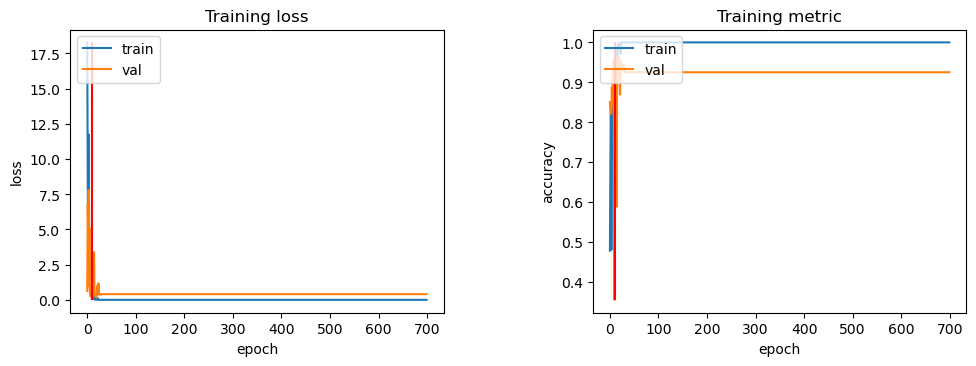

CPU times: total: 2d 13h 53min 7s
Wall time: 10h 20min 18s


In [27]:
%%time
# train model A
modelA = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

optA = torch.optim.Adam(modelA.parameters(), lr=0.001)
loss_fnA = nn.CrossEntropyLoss()


epochs = 700

historyA, best_modelA, best_model_scoreA = train_save_best(model=modelA,
                                                            iterator=train_iter,
                                                            optimizer=optA,
                                                            criterion=loss_fnA,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)

# save model
torch.save(best_modelA, './Models/modelA')

# save history
with open('./Models/historyA.txt', 'w') as dat:
    dat.write(str(historyA))

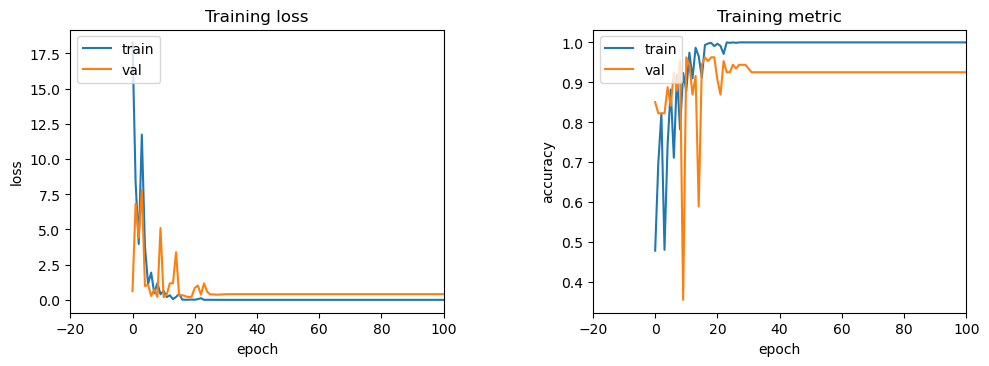

In [31]:
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.5,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

plt.subplot(1, 2, 1)
plt.plot(historyA['train_loss'])
plt.plot(historyA['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training loss')
plt.xlim([-20, 100])

plt.subplot(1, 2, 2)
plt.plot(historyA['train_acc'])
plt.plot(historyA['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training metric')
plt.xlim([-20, 100])

plt.show()

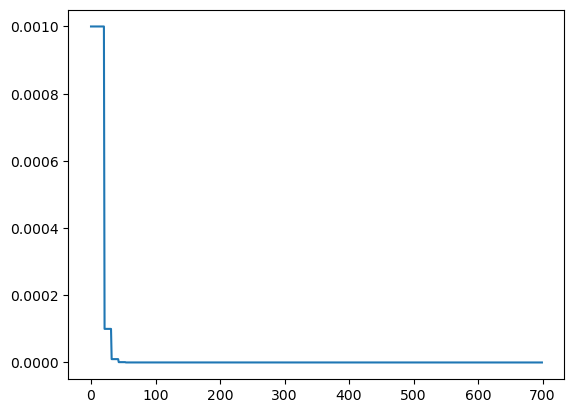

In [32]:
plt.plot(historyA['learning_rate'])

  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_20308\428977846.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 7/7 [01:01<00:00,  8.81s/it]
C:\Users\jjung\AppData\Local\Temp\ipykernel_20308\428977846.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.6443               Validation Loss: 0.4900               Train acc: 0.6460,               Val acc: 0.8224


100%|██████████| 7/7 [00:48<00:00,  6.91s/it]


Epoch: 2  Train Loss: 0.4859               Validation Loss: 0.4638               Train acc: 0.8196,               Val acc: 0.8224


100%|██████████| 7/7 [00:47<00:00,  6.76s/it]


Epoch: 3  Train Loss: 0.4594               Validation Loss: 0.4351               Train acc: 0.8191,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Epoch: 4  Train Loss: 0.4333               Validation Loss: 0.4049               Train acc: 0.8196,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.46s/it]


Epoch: 5  Train Loss: 0.4087               Validation Loss: 0.3887               Train acc: 0.8211,               Val acc: 0.8224


100%|██████████| 7/7 [00:44<00:00,  6.43s/it]


Epoch: 6  Train Loss: 0.3946               Validation Loss: 0.3674               Train acc: 0.8186,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.43s/it]


Epoch: 7  Train Loss: 0.3795               Validation Loss: 0.3554               Train acc: 0.8221,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.48s/it]


Epoch: 8  Train Loss: 0.3624               Validation Loss: 0.3469               Train acc: 0.8244,               Val acc: 0.8224


100%|██████████| 7/7 [00:46<00:00,  6.63s/it]


Epoch: 9  Train Loss: 0.3612               Validation Loss: 0.3371               Train acc: 0.8213,               Val acc: 0.8505


100%|██████████| 7/7 [00:45<00:00,  6.46s/it]


Epoch: 10  Train Loss: 0.3466               Validation Loss: 0.3297               Train acc: 0.8343,               Val acc: 0.8224


100%|██████████| 7/7 [00:44<00:00,  6.43s/it]


Epoch: 11  Train Loss: 0.3410               Validation Loss: 0.3184               Train acc: 0.8294,               Val acc: 0.8505


100%|██████████| 7/7 [00:44<00:00,  6.42s/it]


Epoch: 12  Train Loss: 0.3327               Validation Loss: 0.3149               Train acc: 0.8458,               Val acc: 0.8411


100%|██████████| 7/7 [00:45<00:00,  6.43s/it]


Epoch: 13  Train Loss: 0.3288               Validation Loss: 0.3259               Train acc: 0.8371,               Val acc: 0.8224


100%|██████████| 7/7 [00:44<00:00,  6.40s/it]


Epoch: 14  Train Loss: 0.3244               Validation Loss: 0.3127               Train acc: 0.8449,               Val acc: 0.8224


100%|██████████| 7/7 [00:44<00:00,  6.41s/it]


Epoch: 15  Train Loss: 0.3224               Validation Loss: 0.3013               Train acc: 0.8516,               Val acc: 0.8505


100%|██████████| 7/7 [00:44<00:00,  6.42s/it]


Epoch: 16  Train Loss: 0.3208               Validation Loss: 0.2981               Train acc: 0.8555,               Val acc: 0.8505


100%|██████████| 7/7 [00:45<00:00,  6.45s/it]


Epoch: 17  Train Loss: 0.3148               Validation Loss: 0.2944               Train acc: 0.8562,               Val acc: 0.8505


100%|██████████| 7/7 [00:44<00:00,  6.41s/it]


Epoch: 18  Train Loss: 0.3142               Validation Loss: 0.2928               Train acc: 0.8674,               Val acc: 0.7944


100%|██████████| 7/7 [00:45<00:00,  6.44s/it]


Epoch: 19  Train Loss: 0.3110               Validation Loss: 0.2944               Train acc: 0.8606,               Val acc: 0.8318


100%|██████████| 7/7 [00:45<00:00,  6.44s/it]


Epoch: 20  Train Loss: 0.3051               Validation Loss: 0.2889               Train acc: 0.8585,               Val acc: 0.8131


100%|██████████| 7/7 [00:45<00:00,  6.44s/it]


Epoch: 21  Train Loss: 0.3003               Validation Loss: 0.2844               Train acc: 0.8721,               Val acc: 0.8505


100%|██████████| 7/7 [00:45<00:00,  6.48s/it]


Epoch: 22  Train Loss: 0.2973               Validation Loss: 0.2822               Train acc: 0.8772,               Val acc: 0.8505


100%|██████████| 7/7 [00:45<00:00,  6.46s/it]


Epoch: 23  Train Loss: 0.2969               Validation Loss: 0.2909               Train acc: 0.8637,               Val acc: 0.8318


100%|██████████| 7/7 [00:45<00:00,  6.43s/it]


Epoch: 24  Train Loss: 0.2916               Validation Loss: 0.2781               Train acc: 0.8739,               Val acc: 0.8318


100%|██████████| 7/7 [00:45<00:00,  6.45s/it]


Epoch: 25  Train Loss: 0.2883               Validation Loss: 0.2750               Train acc: 0.8808,               Val acc: 0.8411


100%|██████████| 7/7 [00:45<00:00,  6.44s/it]


Epoch: 26  Train Loss: 0.2897               Validation Loss: 0.2733               Train acc: 0.8765,               Val acc: 0.8411


100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Epoch: 27  Train Loss: 0.2857               Validation Loss: 0.2806               Train acc: 0.8934,               Val acc: 0.8318


100%|██████████| 7/7 [00:44<00:00,  6.41s/it]


Epoch: 28  Train Loss: 0.2846               Validation Loss: 0.2707               Train acc: 0.8741,               Val acc: 0.8505


100%|██████████| 7/7 [00:45<00:00,  6.44s/it]


Epoch: 29  Train Loss: 0.2802               Validation Loss: 0.2918               Train acc: 0.9005,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Epoch: 30  Train Loss: 0.2839               Validation Loss: 0.2686               Train acc: 0.8762,               Val acc: 0.8318


100%|██████████| 7/7 [00:45<00:00,  6.44s/it]


Epoch: 31  Train Loss: 0.2752               Validation Loss: 0.2717               Train acc: 0.8994,               Val acc: 0.8411


100%|██████████| 7/7 [00:45<00:00,  6.45s/it]


Epoch: 32  Train Loss: 0.2731               Validation Loss: 0.2794               Train acc: 0.9005,               Val acc: 0.8318


100%|██████████| 7/7 [00:45<00:00,  6.45s/it]


Epoch: 33  Train Loss: 0.2730               Validation Loss: 0.2646               Train acc: 0.8963,               Val acc: 0.8505


100%|██████████| 7/7 [00:46<00:00,  6.69s/it]


Epoch: 34  Train Loss: 0.2714               Validation Loss: 0.2713               Train acc: 0.8983,               Val acc: 0.8318


100%|██████████| 7/7 [00:46<00:00,  6.70s/it]


Epoch: 35  Train Loss: 0.2657               Validation Loss: 0.2597               Train acc: 0.9016,               Val acc: 0.8785


100%|██████████| 7/7 [00:45<00:00,  6.46s/it]


Epoch: 36  Train Loss: 0.2669               Validation Loss: 0.2695               Train acc: 0.9149,               Val acc: 0.8598


100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Epoch: 37  Train Loss: 0.2680               Validation Loss: 0.2569               Train acc: 0.9020,               Val acc: 0.8879


100%|██████████| 7/7 [00:45<00:00,  6.49s/it]


Epoch: 38  Train Loss: 0.2648               Validation Loss: 0.2558               Train acc: 0.9146,               Val acc: 0.8785


100%|██████████| 7/7 [00:45<00:00,  6.44s/it]


Epoch: 39  Train Loss: 0.2640               Validation Loss: 0.2548               Train acc: 0.9033,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.44s/it]


Epoch: 40  Train Loss: 0.2540               Validation Loss: 0.2641               Train acc: 0.9149,               Val acc: 0.8598


100%|██████████| 7/7 [00:45<00:00,  6.43s/it]


Epoch: 41  Train Loss: 0.2570               Validation Loss: 0.2560               Train acc: 0.9120,               Val acc: 0.8411


100%|██████████| 7/7 [00:45<00:00,  6.44s/it]


Epoch: 42  Train Loss: 0.2557               Validation Loss: 0.2525               Train acc: 0.9150,               Val acc: 0.8692


100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Epoch: 43  Train Loss: 0.2540               Validation Loss: 0.2501               Train acc: 0.9084,               Val acc: 0.8879


100%|██████████| 7/7 [00:47<00:00,  6.73s/it]


Epoch: 44  Train Loss: 0.2461               Validation Loss: 0.2512               Train acc: 0.9206,               Val acc: 0.8785


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 45  Train Loss: 0.2462               Validation Loss: 0.2625               Train acc: 0.9262,               Val acc: 0.8785


100%|██████████| 7/7 [00:45<00:00,  6.48s/it]


Epoch: 46  Train Loss: 0.2485               Validation Loss: 0.2477               Train acc: 0.9222,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.44s/it]


Epoch: 47  Train Loss: 0.2503               Validation Loss: 0.2446               Train acc: 0.9142,               Val acc: 0.8785


100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Epoch: 48  Train Loss: 0.2395               Validation Loss: 0.2579               Train acc: 0.9317,               Val acc: 0.8505


100%|██████████| 7/7 [00:45<00:00,  6.44s/it]


Epoch: 49  Train Loss: 0.2432               Validation Loss: 0.2439               Train acc: 0.9019,               Val acc: 0.8785


100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Epoch: 50  Train Loss: 0.2410               Validation Loss: 0.2583               Train acc: 0.9266,               Val acc: 0.8785


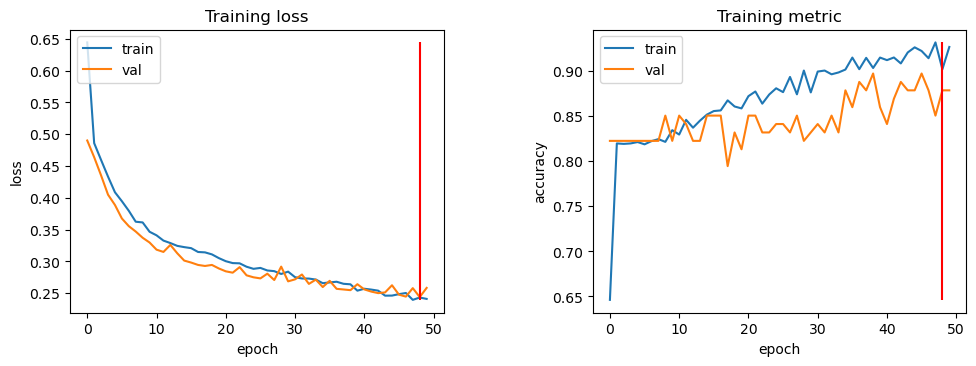

CPU times: total: 3h 57min 45s
Wall time: 39min 48s


In [33]:
%%time
# train model B
modelB = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

optB = torch.optim.SGD(modelB.parameters(), lr=0.001)
loss_fnB = nn.CrossEntropyLoss()


epochs = 50

historyB, best_modelB, best_model_scoreB = train_save_best(model=modelB,
                                                            iterator=train_iter,
                                                            optimizer=optB,
                                                            criterion=loss_fnB,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)

# save model
torch.save(best_modelB, './Models/modelB')

# save history
with open('./Models/historyB.txt', 'w') as dat:
    dat.write(str(historyB))

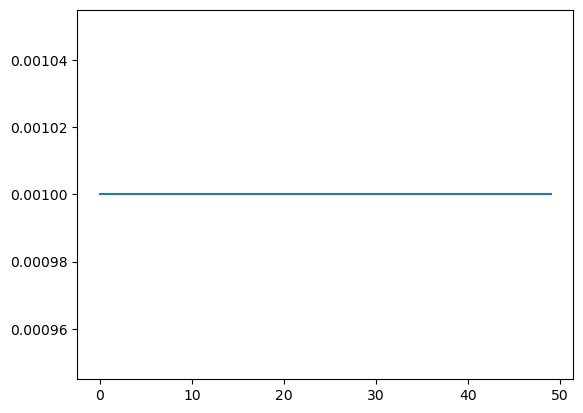

In [34]:
plt.plot(historyB['learning_rate'])

# Model fusion

### Definitions

In [13]:
def weight_averaging(*weights):
  with torch.no_grad():
    sum = torch.zeros(weights[0].shape, device=device)
    for weight in weights:
      sum += weight
  return sum / len(weights)

In [14]:
def linear_averaging(*linears):
  """Averages several linear layers (weights + biases)"""
  with torch.no_grad():
    weights = [linear.weight for linear in linears]
    biases = [linear.bias for linear in linears]

    linear_averaged = torch.nn.Linear(linears[0].in_features, linears[0].out_features, bias=True).to(device)
    linear_averaged.weight, linear_averaged.bias = torch.nn.Parameter(weight_averaging(*weights)), torch.nn.Parameter(weight_averaging(*biases))

  return linear_averaged

In [15]:
def vanilla_fusion(modelA, modelB):
  # init
  model_fusion = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

  with torch.no_grad():
    # 1) encoder
    # TODO: smarter method for embedding
    # a) embedding
    weights_A = modelA.encoder.emb.tok_emb.weight
    weights_B = modelB.encoder.emb.tok_emb.weight

    weights_fusion = weight_averaging(weights_A, weights_B) # weights seem to be exactly the same?
    model_fusion.encoder.emb.tok_emb.weight = torch.nn.Parameter(weights_fusion)

    # b) encoder layers
    for i, _ in enumerate(modelA.encoder.layers):
      # i) self-attention (fuse Q, K, V separately) # TODO: check validity of this approach
      # query
      query_A = modelA.encoder.layers[i].attention.w_q
      query_B = modelB.encoder.layers[i].attention.w_q

      query_fusion = linear_averaging(query_A, query_B)
      model_fusion.encoder.layers[i].attention.w_q = query_fusion

      # key
      key_A = modelA.encoder.layers[i].attention.w_k
      key_B = modelB.encoder.layers[i].attention.w_k

      key_fusion = linear_averaging(key_A, key_B)
      model_fusion.encoder.layers[i].attention.w_k = key_fusion

      # value
      value_A = modelA.encoder.layers[i].attention.w_v
      value_B = modelB.encoder.layers[i].attention.w_v

      value_fusion = linear_averaging(value_A, value_B)
      model_fusion.encoder.layers[i].attention.w_v = value_fusion

      # output
      output_A = modelA.encoder.layers[i].attention.w_concat
      output_B = modelB.encoder.layers[i].attention.w_concat

      output_fusion = linear_averaging(output_A, output_B)
      model_fusion.encoder.layers[i].attention.w_concat = output_fusion

      # ii) layer norm 1
      # TODO: LAYER NORM WEIGHTS ARE NOT CALLABLE???

      # iii) feed-forward network
      # layer 1
      linear_A = modelA.encoder.layers[i].ffn.linear1
      linear_B = modelB.encoder.layers[i].ffn.linear1

      linear_fusion = linear_averaging(linear_A, linear_B)
      model_fusion.encoder.layers[i].ffn.linear1 = linear_fusion

      # layer 2
      linear_A = modelA.encoder.layers[i].ffn.linear2
      linear_B = modelB.encoder.layers[i].ffn.linear2

      linear_fusion = linear_averaging(linear_A, linear_B)
      model_fusion.encoder.layers[i].ffn.linear2 = linear_fusion

      # iv) layer norm 2
      # TODO: LAYER NORM WEIGHTS ARE NOT CALLABLE???

    # 2) MLP head
    linear_A = modelA.linear
    linear_B = modelB.linear

    linear_fusion = linear_averaging(linear_A, linear_B)
    model_fusion.linear = linear_fusion

  return model_fusion

In [16]:
def test_fusion(modelA, modelB, model_fusion):
  # test fusion
  test_loss_A, test_acc_A = validation(modelA, test_iter, None, nn.CrossEntropyLoss(), device)
  test_loss_B, test_acc_B = validation(modelB, test_iter, None, nn.CrossEntropyLoss(), device)
  test_loss_fusion, test_acc_fusion = validation(model_fusion, test_iter, None, nn.CrossEntropyLoss(), device)

  # visualize
  fig, ax = plt.subplots()

  metrics_A = [test_loss_A, test_acc_A]
  metrics_B = [test_loss_B, test_acc_B]
  metrics_fusion = [test_loss_fusion, test_acc_fusion]
  metrics = ['loss', 'accuracy']
  x = np.arange(len(metrics)) # positions of bars (1 per metric)
  width = 0.25  # the width of the bars

  rects1 = ax.bar(x - width, metrics_A, width, label='model A')
  rects2 = ax.bar(x, metrics_B, width, label='model B')
  rects3 = ax.bar(x + width, metrics_fusion, width, label='model fusion')

  ax.set_ylabel('Score')
  ax.set_title('Test metrics by models')
  ax.set_xticks(x)
  ax.set_xticklabels(metrics)
  ax.legend()

  plt.show()

### (Optional) load models

In [17]:
# load parent models
# TODO: change enc_voc_size back
modelA = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)
modelB = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

modelA.load_state_dict(torch.load('./Models/modelA'))
modelB.load_state_dict(torch.load('./Models/modelB'))

<All keys matched successfully>

### Fusion

In [18]:
model_fusion = vanilla_fusion(modelA, modelB)

### Test fusion

C:\Users\jjung\AppData\Local\Temp\ipykernel_1684\317618357.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


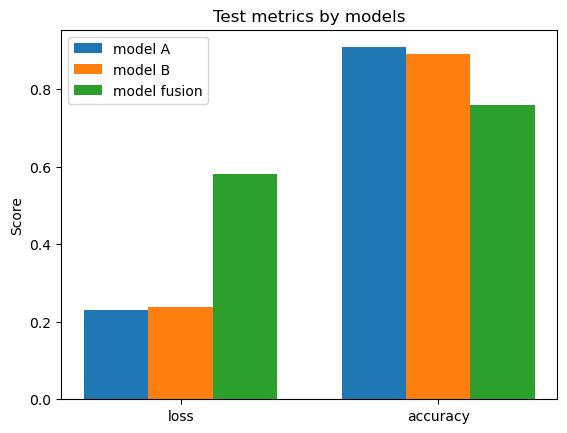

In [19]:
# test with new randomly initialized transformer
test_fusion(modelA, modelB, TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device))

C:\Users\jjung\AppData\Local\Temp\ipykernel_1684\317618357.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


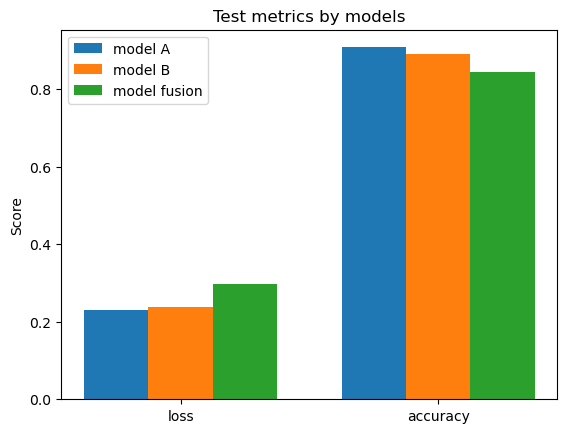

In [20]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion)

### Retraining

  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_1684\317618357.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 7/7 [00:56<00:00,  8.12s/it]
C:\Users\jjung\AppData\Local\Temp\ipykernel_1684\317618357.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.1843               Validation Loss: 0.2260               Train acc: 0.9706,               Val acc: 0.8972


100%|██████████| 7/7 [00:44<00:00,  6.31s/it]


Epoch: 2  Train Loss: 0.1540               Validation Loss: 0.2486               Train acc: 0.9794,               Val acc: 0.8505


100%|██████████| 7/7 [00:44<00:00,  6.38s/it]


Epoch: 3  Train Loss: 0.1620               Validation Loss: 0.2247               Train acc: 0.9683,               Val acc: 0.8879


100%|██████████| 7/7 [00:44<00:00,  6.35s/it]


Epoch: 4  Train Loss: 0.1520               Validation Loss: 0.2223               Train acc: 0.9767,               Val acc: 0.8879


100%|██████████| 7/7 [00:53<00:00,  7.59s/it]


Epoch: 5  Train Loss: 0.1508               Validation Loss: 0.2265               Train acc: 0.9716,               Val acc: 0.8785


100%|██████████| 7/7 [00:50<00:00,  7.22s/it]


Epoch: 6  Train Loss: 0.1542               Validation Loss: 0.2151               Train acc: 0.9701,               Val acc: 0.8972


100%|██████████| 7/7 [00:47<00:00,  6.73s/it]


Epoch: 7  Train Loss: 0.1484               Validation Loss: 0.2127               Train acc: 0.9766,               Val acc: 0.8879


100%|██████████| 7/7 [00:46<00:00,  6.64s/it]


Epoch: 8  Train Loss: 0.1477               Validation Loss: 0.2140               Train acc: 0.9783,               Val acc: 0.9346


100%|██████████| 7/7 [00:46<00:00,  6.69s/it]


Epoch: 9  Train Loss: 0.1462               Validation Loss: 0.2094               Train acc: 0.9750,               Val acc: 0.9065


100%|██████████| 7/7 [00:46<00:00,  6.67s/it]


Epoch: 10  Train Loss: 0.1471               Validation Loss: 0.2091               Train acc: 0.9750,               Val acc: 0.9159


100%|██████████| 7/7 [00:46<00:00,  6.66s/it]


Epoch: 11  Train Loss: 0.1476               Validation Loss: 0.2165               Train acc: 0.9733,               Val acc: 0.8879


100%|██████████| 7/7 [00:46<00:00,  6.67s/it]


Epoch: 12  Train Loss: 0.1449               Validation Loss: 0.2081               Train acc: 0.9717,               Val acc: 0.8879


100%|██████████| 7/7 [00:46<00:00,  6.67s/it]


Epoch: 13  Train Loss: 0.1425               Validation Loss: 0.2045               Train acc: 0.9773,               Val acc: 0.8972


100%|██████████| 7/7 [00:46<00:00,  6.65s/it]


Epoch: 14  Train Loss: 0.1407               Validation Loss: 0.2040               Train acc: 0.9784,               Val acc: 0.8972


100%|██████████| 7/7 [00:46<00:00,  6.69s/it]


Epoch: 15  Train Loss: 0.1379               Validation Loss: 0.2188               Train acc: 0.9839,               Val acc: 0.8879


100%|██████████| 7/7 [00:46<00:00,  6.69s/it]


Epoch: 16  Train Loss: 0.1385               Validation Loss: 0.2181               Train acc: 0.9788,               Val acc: 0.8879


100%|██████████| 7/7 [00:46<00:00,  6.68s/it]


Epoch: 17  Train Loss: 0.1428               Validation Loss: 0.2292               Train acc: 0.9682,               Val acc: 0.8692


100%|██████████| 7/7 [00:46<00:00,  6.70s/it]


Epoch: 18  Train Loss: 0.1437               Validation Loss: 0.2029               Train acc: 0.9672,               Val acc: 0.8879


100%|██████████| 7/7 [00:46<00:00,  6.68s/it]


Epoch: 19  Train Loss: 0.1343               Validation Loss: 0.2037               Train acc: 0.9778,               Val acc: 0.8879


100%|██████████| 7/7 [00:50<00:00,  7.21s/it]


Epoch: 20  Train Loss: 0.1405               Validation Loss: 0.2053               Train acc: 0.9750,               Val acc: 0.9439


100%|██████████| 7/7 [00:50<00:00,  7.23s/it]


Epoch: 21  Train Loss: 0.1391               Validation Loss: 0.2030               Train acc: 0.9795,               Val acc: 0.8879


100%|██████████| 7/7 [00:50<00:00,  7.19s/it]


Epoch: 22  Train Loss: 0.1363               Validation Loss: 0.2010               Train acc: 0.9805,               Val acc: 0.9346


100%|██████████| 7/7 [00:50<00:00,  7.21s/it]


Epoch: 23  Train Loss: 0.1359               Validation Loss: 0.2178               Train acc: 0.9728,               Val acc: 0.9252


100%|██████████| 7/7 [00:50<00:00,  7.20s/it]


Epoch: 24  Train Loss: 0.1383               Validation Loss: 0.1994               Train acc: 0.9806,               Val acc: 0.9346


100%|██████████| 7/7 [00:50<00:00,  7.19s/it]


Epoch: 25  Train Loss: 0.1311               Validation Loss: 0.2157               Train acc: 0.9777,               Val acc: 0.8879


100%|██████████| 7/7 [00:50<00:00,  7.22s/it]


Epoch: 26  Train Loss: 0.1337               Validation Loss: 0.1981               Train acc: 0.9794,               Val acc: 0.9252


100%|██████████| 7/7 [00:50<00:00,  7.17s/it]


Epoch: 27  Train Loss: 0.1344               Validation Loss: 0.2052               Train acc: 0.9811,               Val acc: 0.9439


100%|██████████| 7/7 [00:50<00:00,  7.21s/it]


Epoch: 28  Train Loss: 0.1365               Validation Loss: 0.1977               Train acc: 0.9834,               Val acc: 0.8972


100%|██████████| 7/7 [00:50<00:00,  7.21s/it]


Epoch: 29  Train Loss: 0.1364               Validation Loss: 0.1963               Train acc: 0.9784,               Val acc: 0.9065


100%|██████████| 7/7 [00:50<00:00,  7.19s/it]


Epoch: 30  Train Loss: 0.1306               Validation Loss: 0.1970               Train acc: 0.9828,               Val acc: 0.9346


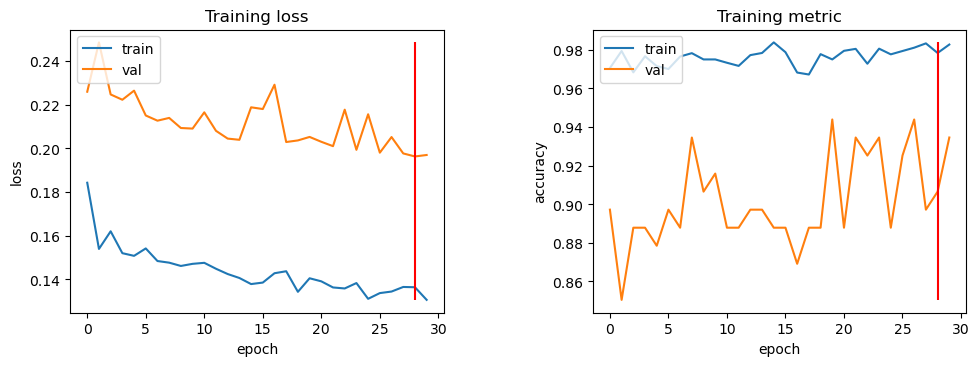

CPU times: total: 2h 30min 26s
Wall time: 25min 16s


In [21]:
%%time
opt_fusion = torch.optim.SGD(model_fusion.parameters(), lr=0.001)
loss_fn_fusion = nn.CrossEntropyLoss()


epochs = 30
history_fusion, best_model_fusion, best_model_score_fusion = train_save_best(model=model_fusion,
                                                                             iterator=train_iter,
                                                                             optimizer=opt_fusion,
                                                                             criterion=loss_fn_fusion,
                                                                             epoch=epochs,
                                                                             clip=1,
                                                                             device=device)

In [22]:
model_fusion.load_state_dict(best_model_fusion)

<All keys matched successfully>

### Test fusion (after retraining)

C:\Users\jjung\AppData\Local\Temp\ipykernel_1684\317618357.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


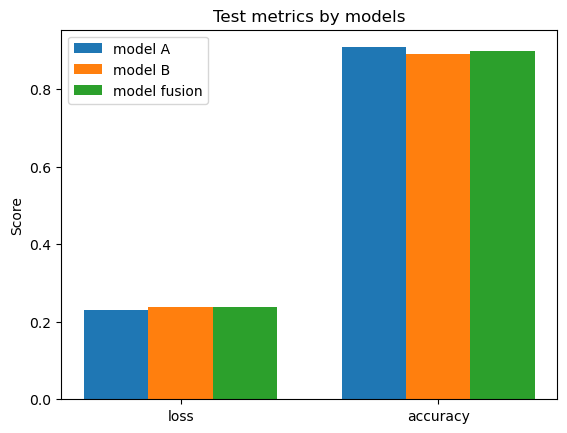

In [23]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion)